# Customer Churn Prediction


This script is for Customer Churn Prediction, comparing the results of Random Forest Classifier, Logistic Regression and Gradient Boosting with different hyperparameter values.

In [1]:
##### Inicial configuration

# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV 
import category_encoders as ce

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Display configuration

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)
pd.set_option('display.expand_frame_repr', False)
pd.options.display.float_format = '{:20,.2f}'.format

## Preprocessing Data

In [33]:
# Reading Data

base_url = 'https://github.com/thatiane-tomaz/customer_churn_pred/tree/main/data/churn_modelling.csv'
df = pd.read_csv(base_url)


In [34]:
# Checking for missing data

df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [36]:
# Preprocessing and Feature Engineering

# Drop unwanted columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Defining Categorical Variables
cat_vars = ['Geography', 'Gender']

# Creating squared Estimate Salary ans Balance
df['EstimatedSalary2'] = df['EstimatedSalary']**2
df['Balance2'] = df['Balance']**2

## Classification Model

In [37]:
# Defining features, labels and tain/test datasets

X = df.drop(['Exited', 'bin_age', 'bin_income', 'bin_balance'], axis=1)

onehot_enc = ce.OneHotEncoder(use_cat_names = True, handle_unknown = 'ignore').fit(X[cat_vars])
onehot_vars = onehot_enc.transform(X[cat_vars])
    
X = X.drop(cat_vars, axis=1)
X = pd.concat([X, onehot_vars], axis = 1)

y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
# Checking best model and hyperparameters

pipe_rf = Pipeline([('pca', PCA()),
                    ('rf_classifier', RandomForestClassifier())])

pipe_lr = Pipeline([('pca', PCA()),
                    ('lr_classifier', LogisticRegression(random_state = 0))])

pipe_gb = Pipeline([('pca', PCA()),
                    ('gb_classifier', GradientBoostingClassifier())])

# Set grid search params
pca_comp = [6, 8, 10, 12]

param_grid_rf = {
    'pca__n_components': pca_comp,
    'rf_classifier__max_depth': [20, 40, 60, 80],
    'rf_classifier__min_samples_leaf': [3, 4, 5],
    'rf_classifier__min_samples_split': [8, 10, 12],
}

param_grid_lr = {
    'pca__n_components': pca_comp,
    'lr_classifier__penalty' : ['l1', 'l2'],
    'lr_classifier__C' : np.logspace(-4, 4, 20),
}

param_grid_gb = {
    'pca__n_components': pca_comp,
    'gb_classifier__max_depth': [20, 40, 60, 80],
    'gb_classifier__min_samples_leaf': [3, 4, 5],
    'gb_classifier__min_samples_split': [8, 10, 12],
}

# Constructing grid searches
jobs = -1

gs_rf = GridSearchCV(estimator=pipe_rf,param_grid=param_grid_rf,scoring='accuracy',cv=5) 

gs_lr = GridSearchCV(estimator=pipe_lr,param_grid=param_grid_lr,scoring='accuracy',cv=5) 

gs_gb = GridSearchCV(estimator=pipe_gb,param_grid=param_grid_gb,scoring='accuracy',cv=5) 


# List of pipelines for ease of iteration
grids = [gs_rf, gs_lr, gs_gb]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'RandomForest', 1:'LogisticRegression', 2:'GradientBoosting'}

# Fit the grid search objects

print('Performing model optimizations...')
best_accuracy = 0
best_classifier = 0
for i, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[i])
    # Fit 
    gs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    print('Test set accuracy score for best params: %.3f ' % accuracy_score(y_test, y_pred))
    # Track best (highest test accuracy) model
    if accuracy_score(y_test, y_pred) > best_accuracy:
        best_accuracy = accuracy_score(y_test, y_pred)
        best_classifier = i
print('\nClassifier with best test set accuracy: %s' % grid_dict[best_classifier])

Performing model optimizations...

Estimator: RandomForest
Best params: {'pca__n_components': 12, 'rf_classifier__max_depth': 80, 'rf_classifier__min_samples_leaf': 3, 'rf_classifier__min_samples_split': 10}
Test set accuracy score for best params: 0.870 

Estimator: LogisticRegression
Best params: {'lr_classifier__C': 0.0001, 'lr_classifier__penalty': 'l2', 'pca__n_components': 6}
Test set accuracy score for best params: 0.548 

Estimator: GradientBoosting
Best params: {'gb_classifier__max_depth': 40, 'gb_classifier__min_samples_leaf': 5, 'gb_classifier__min_samples_split': 10, 'pca__n_components': 12}
Test set accuracy score for best params: 0.865 

Classifier with best test set accuracy: RandomForest


In [54]:
model = gs_rf.best_estimator_

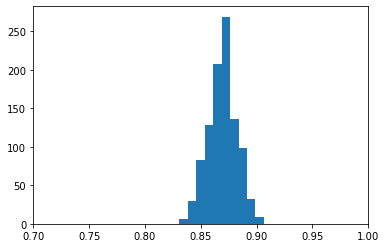

95.0 confidence interval for accuracy between 84.3% and 89.5%


In [60]:
# Evaluating the model by Bootstrap

y_pred = model.predict(X_test)
scores = []

# evaluate model
df_boot = pd.DataFrame({'y_true': y_test, 'y_pred':y_pred})
n_iterations = 1000
n_size = int(len(df_boot) * 0.25)
for i in range(n_iterations):
    sample = resample(df_boot, n_samples = n_size)
    score = accuracy_score(sample.y_true, sample.y_pred)
    scores.append(score)

plt.hist(scores)
plt.xlim([0.7, 1])
plt.show()

# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
ci_lower = max(0.0, np.percentile(scores, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
ci_upper = min(1.0, np.percentile(scores, p))

print('%.1f confidence interval for accuracy between %.1f%% and %.1f%%' % (alpha*100, ci_lower*100, ci_upper*100))

In [56]:
# classification report for precision, recall f1-score and accuracy

matrix = classification_report(y_test,y_pred,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       0.77      0.47      0.58       584
           0       0.88      0.97      0.92      2416

    accuracy                           0.87      3000
   macro avg       0.83      0.72      0.75      3000
weighted avg       0.86      0.87      0.86      3000



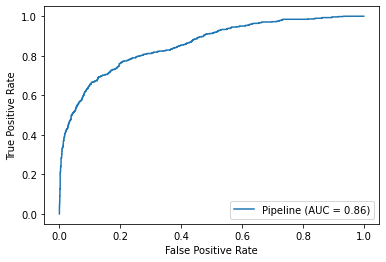

In [57]:
# ROC Curve Plot
metrics.plot_roc_curve(model, X_test, y_test)  
>>> plt.show()